In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = [12, 6]

import wandb
from wandb.keras import WandbCallback

import random

In [2]:
time_point_ids = ["hhgat", "maput", "cntsq", "mit", "hynes", "masta", "Wasma", "Melwa", "Dudly"]
date_cols = ["service_date"] + time_point_ids

trip_data = pd.read_csv("../data/one_trips.csv",
                         index_col="half_trip_id", 
                         parse_dates = date_cols)
print(len(trip_data))
trip_data.head()

9078


,service_date,duration,hhgat,maput,cntsq,mit,hynes,masta,Wasma,Melwa,Dudly
half_trip_id,,,,,,,,,,,
46202752.0,2020-01-01,1913,1900-01-01 06:49:49,1900-01-01 06:53:22,1900-01-01 06:58:01,1900-01-01 07:01:52,1900-01-01 07:05:57,1900-01-01 07:12:25,1900-01-01 07:14:42,1900-01-01 07:20:57,1900-01-01 07:21:42
46202754.0,2020-01-01,1294,1900-01-01 07:49:34,1900-01-01 07:53:04,1900-01-01 07:55:01,1900-01-01 07:57:18,1900-01-01 07:59:36,1900-01-01 08:03:12,1900-01-01 08:06:34,1900-01-01 08:10:23,1900-01-01 08:11:08
46202756.0,2020-01-01,1625,1900-01-01 08:57:33,1900-01-01 09:01:42,1900-01-01 09:04:40,1900-01-01 09:09:07,1900-01-01 09:12:35,1900-01-01 09:14:51,1900-01-01 09:18:13,1900-01-01 09:23:52,1900-01-01 09:24:38
46202758.0,2020-01-01,1862,1900-01-01 10:19:20,1900-01-01 10:22:57,1900-01-01 10:26:10,1900-01-01 10:29:26,1900-01-01 10:33:48,1900-01-01 10:38:45,1900-01-01 10:44:08,1900-01-01 10:49:34,1900-01-01 10:50:22
46202760.0,2020-01-01,1935,1900-01-01 11:54:27,1900-01-01 11:59:07,1900-01-01 12:02:49,1900-01-01 12:07:55,1900-01-01 12:13:00,1900-01-01 12:17:51,1900-01-01 12:21:24,1900-01-01 12:26:08,1900-01-01 12:26:42


In [39]:
# Building datasets

prev_stops = ["hhgat", "maput", "cntsq", "mit", "hynes", "masta"]
current_stop = "masta"
target_stop = "Dudly"

trip_features = pd.DataFrame({
    "current_time": trip_data[current_stop],
    "to_target": (trip_data[target_stop] - trip_data[current_stop]).dt.seconds,
    'service_date': trip_data.service_date
})

leg_history = pd.DataFrame({
    "to_"+ prev_stops[i]: (trip_data[prev_stops[i]] - trip_data[prev_stops[i-1]]).dt.seconds
    for i in range(1, len(prev_stops))
})

def get_headways(df, stop):
    df_sorted = df.sort_values(['service_date', stop])
    return df_sorted.current_time.diff()

trip_features['headway'] = get_headways(trip_features, 'current_time').dt.seconds
trip_features['current_time'] = (trip_features.current_time - pd.to_datetime("1900-01-01")).dt.seconds

ONE_HOT_WEEKDAY = True
if ONE_HOT_WEEKDAY:
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday','friday', 'saturday','sunday']
    for i, day in enumerate(weekdays):
        trip_features[day] = (trip_features.service_date.dt.weekday==i).astype('float')
else:
    trip_features['weekday'] = (trip_features.service_date.dt.weekday < 5).astype('float')
del trip_features['service_date']
    
row_is_na = trip_features.isna().any(axis=1) | leg_history.isna().any(axis=1)

trip_features = trip_features[~row_is_na]
leg_history = leg_history[~row_is_na]

trip_features = trip_features[["current_time", "headway"]+weekdays+["to_target"]]

print("trip_data of shape ", trip_features.shape)
trip_features.head()

trip_data of shape  (9077, 10)


,current_time,headway,monday,tuesday,wednesday,thursday,friday,saturday,sunday,to_target
half_trip_id,,,,,,,,,,
46202752.0,25945,2552.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,557
46202754.0,28992,1042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,476
46202756.0,33291,1220.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,587
46202758.0,38325,1165.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,697
46202760.0,44271,1257.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,531


In [40]:
print("leg_history of shape ", leg_history.shape)
leg_history.head()

leg_history of shape  (9077, 5)


,to_maput,to_cntsq,to_mit,to_hynes,to_masta
half_trip_id,,,,,
46202752.0,213,279,231,245,388
46202754.0,210,117,137,138,216
46202756.0,249,178,267,208,136
46202758.0,217,193,196,262,297
46202760.0,280,222,306,305,291


In [130]:
history_input = keras.Input(shape=(None, 6), name="history")
hist_enc = layers.LSTM(units=3)(history_input)

trip_input = keras.Input(shape=(9,), name="trip")

x = layers.concatenate([hist_enc, trip_input])
x = layers.Dense(units=32, activation='relu')(x)
x = layers.Dense(units=32, activation='relu')(x)
x = layers.Dense(units=32, activation='relu')(x)
output = layers.Dense(units=1)(x)

model = keras.Model(
    inputs=[trip_input, history_input],
    outputs=output
)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None, 6)]    0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 3)            120         history[0][0]                    
__________________________________________________________________________________________________
trip (InputLayer)               [(None, 9)]          0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 12)           0           lstm_6[0][0]                     
                                                                 trip[0][0]                 

Todo: 
 - fix split_dataset
 - think about normalization of arrival times

In [120]:
target_col = "to_target"

trip_train = trip_features.sample(frac=.7)
trip_test = trip_features.loc[~trip_features.index.isin(trip_train.index)]

y_train = trip_train.pop(target_col).to_numpy()
y_test = trip_test.pop(target_col).to_numpy()

x_trip_train = trip_train.to_numpy()
x_trip_test = trip_test.to_numpy()

In [122]:
leg_history_np = leg_history.to_numpy()

# normalize values
leg_history_np = (leg_history_np - leg_history_np.mean()) / leg_history_np.std()

leg_history_train = leg_history_np[trip_features.index.isin(trip_train.index)]
leg_history_test = leg_history_np[~trip_features.index.isin(trip_train.index)]

def truncate_and_reshape(h):
    truncated_length = random.randint(1, len(h))
    one_hot = lambda v: [int(i==v) for i in range(len(h))]
    return [[h[i]]+one_hot(i) for i in range(truncated_length)]

def process_leg_history(leg_history):
    """
    Input: 2d numpy array
    Output: 3d ragged tensor with shape [# datapoints, (len history), 2]
    """
    return tf.ragged.constant([truncate_and_reshape(h) for h in leg_history])

leg_history_train = process_leg_history(leg_history_train)
leg_history_test = process_leg_history(leg_history_test)

leg_history_train[:1]

<tf.RaggedTensor [[[-0.9080954783053696, 1.0, 0.0, 0.0, 0.0, 0.0], [-1.741039043960697, 0.0, 1.0, 0.0, 0.0, 0.0]]]>

In [131]:
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(x_trip_train)
x_trip_train = normalizer(x_trip_train)
x_trip_test = normalizer(x_trip_test)
    
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss="mean_squared_error")

fit_args = {
    "x":{"trip": x_trip_train, "history": leg_history_train},
    "y": y_train,
    "validation_data": ({"trip": x_trip_test, "history": leg_history_test}, y_test),
    "batch_size": 1,
    "epochs": 50,
}

history = model.fit(**fit_args)

Epoch 1/50
6354/6354 [==============================] - 41s 6ms/step - loss: 516181.5860 - val_loss: 78620.7031
Epoch 2/50
6354/6354 [==============================] - 32s 5ms/step - loss: 69954.6746 - val_loss: 74921.7266
Epoch 3/50
6354/6354 [==============================] - 27s 4ms/step - loss: 75286.5149 - val_loss: 74634.2500
Epoch 4/50
6354/6354 [==============================] - 27s 4ms/step - loss: 62471.7781 - val_loss: 72930.4062
Epoch 5/50
6354/6354 [==============================] - 26s 4ms/step - loss: 66697.2305 - val_loss: 73422.4141
Epoch 6/50
6354/6354 [==============================] - 25s 4ms/step - loss: 70324.9991 - val_loss: 73028.2109
Epoch 7/50
6354/6354 [==============================] - 25s 4ms/step - loss: 64754.5248 - val_loss: 72298.8203
Epoch 8/50
6354/6354 [==============================] - 23s 4ms/step - loss: 66618.0316 - val_loss: 72769.3125
Epoch 9/50
6354/6354 [==============================] - 25s 4ms/step - loss: 62521.9616 - val_loss: 71615.2266


In [124]:
predictions = model.predict({"trip": x_trip_test, "history": leg_history_test})

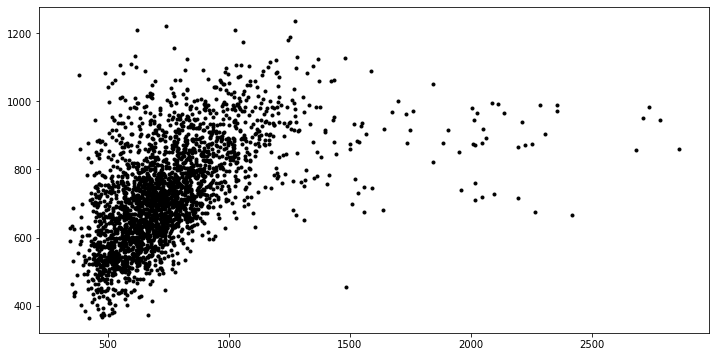

In [125]:
plt.plot(y_test, predictions, ".k")

In [126]:
print("r^2: ", np.corrcoef(y_test, predictions.reshape(-1) )[0,1]**2)

r^2:  0.2783817639792678


In [127]:
def plot_of_len(i):
    of_len = leg_history_test.row_lengths()==i
    print("r^2: ", np.corrcoef(y_test[of_len], predictions[of_len].reshape(-1) )[0,1]**2)
    plt.plot(y_test[of_len], predictions[of_len], ".k")

r^2:  0.3221918852306404


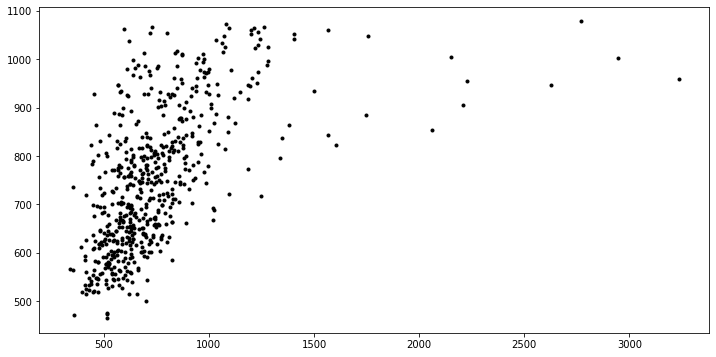

In [114]:
plot_of_len(1)

r^2:  0.3188271842217697


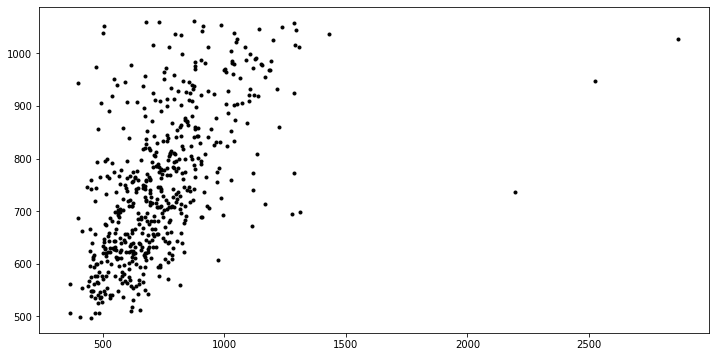

In [115]:
plot_of_len(2)

r^2:  0.312665905451114


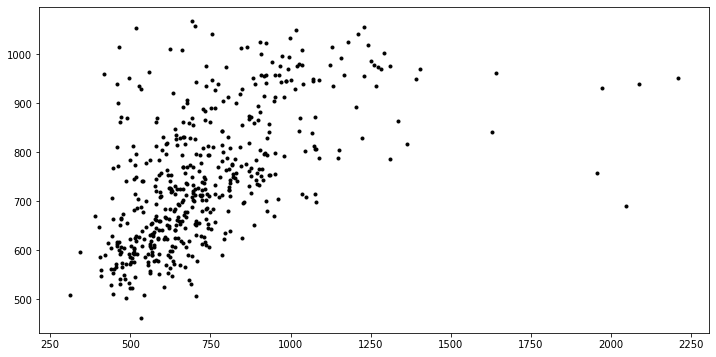

In [116]:
plot_of_len(3)

r^2:  0.2991902844725543


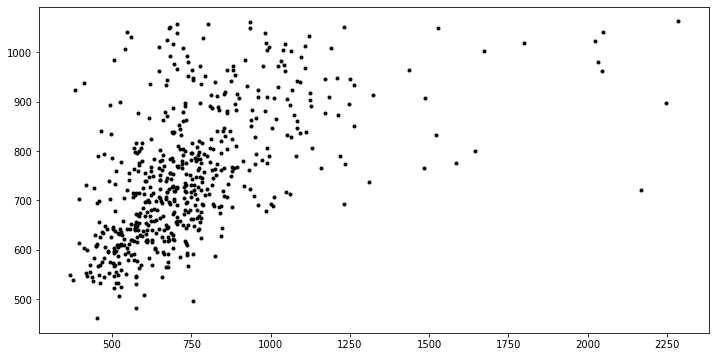

In [117]:
plot_of_len(4)

r^2:  0.30485732560985157


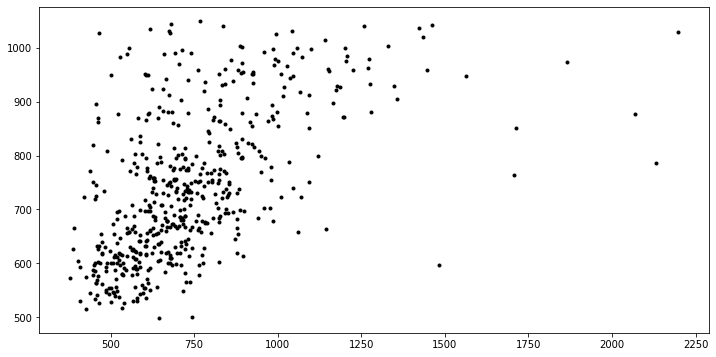

In [118]:
plot_of_len(5)